# Clean up the dataset

In [6]:
# imports
from pyspark.sql import SparkSession, functions, types, Row
import sys
assert sys.version_info >= (3, 5)
import re

# Configuration
## DataFrames
spark = SparkSession.builder.appName('Analysis').getOrCreate()
spark.sparkContext.setLogLevel('WARN')
assert spark.version >= '3.0'  # make sure we have Spark 3.0+
## RDDs
sc = spark.sparkContext
assert sc.version >= '3.0'

In [11]:
# General variables
data_path = "../data.nosync"

## Metadata
### Stations
See [documentation](https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt)
IV. FORMAT OF "ghcnd-stations.txt"

In [12]:
def parse_line(line):
    id = '(\S+)'
    latitude = '([-+]?(?:\d*\.\d+|\d+))'
    longitude = '([-+]?(?:\d*\.\d+|\d+))'
    elevation = '([-+]?(?:\d*\.\d+|\d+))'
    state = '([-a-zA-Z0-9_][-a-zA-Z0-9_])'
    name = '((\S+\s)+)'
    delimiter = '\s+'
    any = ".*"
    line_re = re.compile(r'^'+ id + delimiter + latitude + delimiter + longitude + delimiter + elevation + delimiter + state + delimiter + name + any + '$')
    splitted_line = re.match(line_re, line)
    return Row(splitted_line.group(1), float(splitted_line.group(2)), float(splitted_line.group(3)), float(splitted_line.group(4)), splitted_line.group(5), splitted_line.group(6))

In [13]:
def stations_schema():
    return types.StructType([
        types.StructField("id", types.StringType()),
        types.StructField("latitude", types.FloatType()),
        types.StructField("longitude", types.FloatType()),
        types.StructField("elevation", types.FloatType()),
        types.StructField("state", types.StringType()),
        types.StructField("name", types.StringType()),
        #types.StructField("gsn_flag", types.StringType()),
        #types.StructField("crn_flag", types.StringType()),
        #types.StructField("wmo_id", types.StringType()),
    ])

In [14]:
stations_input = sc.textFile(data_path + "/ghcnd-stations.txt")
formatted_lines = stations_input.filter(lambda line: line.startswith("CA")).map(parse_line)
cleaned_stations = spark.createDataFrame(data=formatted_lines, schema = stations_schema())
cleaned_stations.show()

+-----------+--------+---------+---------+-----+--------------------+
|         id|latitude|longitude|elevation|state|                name|
+-----------+--------+---------+---------+-----+--------------------+
|CA001010066| 48.8667|-123.2833|      4.0|   BC|        ACTIVE PASS |
|CA001010235|    48.4|-123.4833|     17.0|   BC|        ALBERT HEAD |
|CA001010595| 48.5833|-123.5167|     85.0|   BC|BAMBERTON OCEAN C...|
|CA001010720|    48.5|   -124.0|    351.0|   BC|         BEAR CREEK |
|CA001010774|    48.5|  -123.35|     61.0|   BC|        BEAVER LAKE |
|CA001010780| 48.3333|-123.6333|     12.0|   BC|         BECHER BAY |
|CA001010960|    48.6|-123.4667|     38.0|   BC|    BRENTWOOD BAY 2 |
|CA001010961| 48.5667|  -123.45|     31.0|   BC|BRENTWOOD CLARKE ...|
|CA001010965| 48.5667|-123.4333|     91.0|   BC|BRENTWOOD W SAANI...|
|CA001011467| 48.5833|-123.4167|     53.0|   BC|CENTRAL SAANICH V...|
|CA0010114F6| 48.5667|   -123.4|     38.0|   BC|CENTRAL SAANICH I...|
|CA0010114FF|   48.5

In [ ]:
# run only once
# cleaned_stations.write.parquet(data_path + "/ghcnd-stations-cleaned", mode="overwrite")

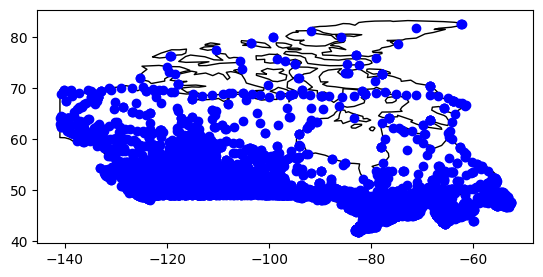

In [46]:
# Plot stations with pandas
import geopandas
import matplotlib.pyplot as plt

cleaned_stations_pd = cleaned_stations.toPandas()

gdf = geopandas.GeoDataFrame(
    cleaned_stations_pd, geometry=geopandas.points_from_xy(cleaned_stations_pd.longitude, cleaned_stations_pd.latitude))

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

# We restrict to Canada (other option: continent = "North America")
ax = world[world.name == 'Canada'].plot(
    color='white', edgecolor='black')

# We can now plot our ``GeoDataFrame``.
gdf.plot(ax=ax, color='blue')

plt.show()

### Countries
See [documentation](https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt)
V. FORMAT OF "ghcnd-countries.txt"

In [ ]:
def parse_line(line):
    code = '([A-Z][A-Z])\s'
    name = '(([,A-Za-z\[\]\(\)]+\s*)+)'
    line_re = re.compile(r'^'+ code + name + '\s*$')
    splitted_line = re.match(line_re, line)
    return Row(splitted_line.group(1), splitted_line.group(2))

In [ ]:
def countries_schema():
    return types.StructType([
        types.StructField("code", types.StringType()),
        types.StructField("name", types.StringType()),
    ])

In [ ]:
countries_input = sc.textFile(data_path + "/ghcnd-countries.txt")
formatted_lines = countries_input.map(parse_line)
cleaned_countries = spark.createDataFrame(data=formatted_lines, schema = countries_schema())
cleaned_countries.show()

### States
See [documentation](https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt)
VI. FORMAT OF "ghcnd-states.txt"

In [ ]:
def parse_line(line):
    code = '([A-Z][A-Z])\s'
    name = '(([A-Z]+\s*)+)'
    line_re = re.compile(r'^'+ code + name + '\s*$')
    splitted_line = re.match(line_re, line)
    return Row(splitted_line.group(1), splitted_line.group(2))

In [ ]:
def states_schema():
    return types.StructType([
        types.StructField("code", types.StringType()),
        types.StructField("name", types.StringType()),
    ])

In [ ]:
states_input = sc.textFile(data_path + "/ghcnd-states.txt")
formatted_lines = states_input.map(parse_line)
cleaned_states = spark.createDataFrame(data=formatted_lines, schema = states_schema())
cleaned_states.show()

### Inventory
See [documentation](https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt)
VII. FORMAT OF "ghcnd-inventory.txt"

In [ ]:
# Cleanup
def toDF(data):
    splitted_data = data.split(" ")
    while "" in splitted_data:
        splitted_data.remove("")

    return Row(splitted_data[0], float(splitted_data[1]), float(splitted_data[2]), splitted_data[3], int(splitted_data[4]), int(splitted_data[5]))

In [ ]:
def inventory_schema():
    return types.StructType([
        types.StructField("id", types.StringType()),
        types.StructField("latitude", types.FloatType()),
        types.StructField("longitude", types.FloatType()),
        types.StructField("element", types.StringType()),
        types.StructField("first_year", types.IntegerType()),
        types.StructField("last_year", types.IntegerType()),
    ])

In [ ]:
inventory_input = sc.textFile(data_path + "/ghcnd-inventory.txt")
formatted_lines = inventory_input.filter(lambda line: line.startswith("CA")).map(toDF)
cleaned_inventory = spark.createDataFrame(data=formatted_lines, schema = inventory_schema()).cache()
cleaned_inventory.show()

In [ ]:
#cleaned_inventory.write.parquet(data_path + "/ghcnd-inventory-cleaned", mode="overwrite")

## Data
### Daily summaries latest


In [ ]:
def daily_summaries_schema():
    return types.StructType([
        types.StructField("station", types.StringType()),
        types.StructField("date", types.StringType()),
        types.StructField("latitude", types.StringType()),
        types.StructField("longtitude", types.StringType()),
        types.StructField("elevation", types.StringType()),
        types.StructField("name", types.StringType()),
        types.StructField("prcp", types.StringType()),
        types.StructField("prcp_attributes", types.StringType()),
        types.StructField("snow", types.StringType()),
        types.StructField("snow_attributes", types.StringType()),
        types.StructField("snwd", types.StringType()),
        types.StructField("snwd_attributes", types.StringType()),
        types.StructField("dapr", types.StringType()),
        types.StructField("dapr_attributes", types.StringType()),
        types.StructField("mdpr", types.StringType()),
        types.StructField("mdpr_attributes", types.StringType()),
        types.StructField("wesd", types.StringType()),
        types.StructField("wesd_attributes", types.StringType()),
    ])
# show the data for the station CA1AB000001
daily_summaries_data = spark.read.csv(data_path + "/ghcnd-daily-summaries-latest-canada/CA1AB000001.csv", sep=",", header=True)
daily_summaries_data.show()

### GHCND-all
See [documentation](https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt)
III. FORMAT OF DATA FILES (".dly" FILES)

In [ ]:
def parse_line(line):
    station = line[:11]
    year = line[11:15]
    month = line[15:17]
    element = line[17:21]
    start_index=21
    data = [station, year, month, element]
    for i in range(31):
        value_i = line[start_index:start_index+5]
        mflag_i = line[start_index+5:start_index+6]
        qflag_i = line[start_index+6:start_index+7]
        sflag_i = line[start_index+7:start_index+8]
        start_index=start_index+8
        data.append(int(value_i))
        data.append(mflag_i)
        data.append(qflag_i)
        data.append(sflag_i)

    return data

def ghcnd_all_columns():
    columns = ["station", "year", "month", "element"]
    for i in range(31):
        value_i = "value" + str(i+1)
        mflag_i = "mflag" + str(i+1)
        qflag_i = "qflag" + str(i+1)
        sflag_i = "sflag" + str(i+1)
        columns.append(value_i)
        columns.append(mflag_i)
        columns.append(qflag_i)
        columns.append(sflag_i)

    return columns

In [ ]:
ghcnd_all_input = sc.textFile(data_path + "/ghcnd-all-canada/")
formatted_lines = ghcnd_all_input.map(parse_line)
cleaned_ghcnd_all = formatted_lines.toDF(ghcnd_all_columns())
cleaned_ghcnd_all.show()

In [ ]:
# Run the following command only once
# cleaned_ghcnd_all.write.partitionBy("station").parquet(data_path + "/ghcnd-all-canada-cleaned", mode="overwrite")

_______________
# ANALYSIS
Questions:
- what is a multiday? - lasting for more than one day: HOW LONG
- how to interpret the weather data?? 1? X? does 1 mean true? And -9999 like false?
-

In [ ]:
# wind speed in tenth of meters per second
wind_day_average_speed = "AWND"
wind_day_max_1min_speed = "WSF1"
wind_day_max_2min_speed = "WSF2"
wind_day_max_5min_speed = "WSF5"
wind_day_max_instantaneous_speed = "WSFI"
wind_day_peak_speed = "WSFG"
wind_speed = [wind_day_average_speed, wind_day_max_1min_speed, wind_day_max_2min_speed, wind_day_max_5min_speed, wind_day_max_instantaneous_speed, wind_day_peak_speed]

# wind movement in km/h
wind_time_max_movement = "FMTM"
wind_multiday_movement = "MDWM"
wind_multiday_movement_number_of_days = "DAWM"
wind_day_movement = "WDMV"
wind_movement = [wind_time_max_movement, wind_multiday_movement, wind_multiday_movement_number_of_days, wind_day_movement]

# wind directions in degree
wind_day_average_direction = "AWDR"
wind_day_max_1min_direction = "WDF1"
wind_day_max_2min_direction = "WDF2"
wind_day_max_5min_direction = "WDF5"
wind_day_peak_direction = "WDFG"
wind_day_max_instantaneous_direction = "WDFI"
wind_direction = [wind_day_average_direction, wind_day_max_1min_direction, wind_day_max_2min_direction, wind_day_max_5min_direction, wind_day_peak_direction, wind_day_max_instantaneous_direction]

# temperature in tenths of degrees C
temperature_day_min = "TMIN"
temperature_multiday_min = "MDTN"
temperature_multiday_min_number_of_days = "DATN"
temperature_day_max = "TMAX"
temperature_multiday_max = "MDTX"
temperature_multiday_max_number_of_days = "DATX"
temperature = [temperature_day_min, temperature_multiday_min, temperature_multiday_min_number_of_days, temperature_day_max, temperature_multiday_max, temperature_multiday_max_number_of_days]

# wheather types
weather_tornado = "WT10"
weather_thunder = "WT03"
weather_damaging_winds = "WT11"
weather_blowing_spray = "WT12"
weather = [weather_tornado, weather_thunder, weather_damaging_winds, weather_blowing_spray]

elements_of_interest = wind_speed + wind_direction + wind_movement + temperature + weather

In [ ]:
from pyspark.sql.functions import collect_list

list_of_elements_per_station = cleaned_inventory.groupby(cleaned_inventory["id"]).agg(collect_list(cleaned_inventory["element"]).alias("elements"))
number_of_elements_per_station = cleaned_inventory.groupby(cleaned_inventory["id"]).agg(functions.count(cleaned_inventory["element"]).alias("number_of_elements"))

inventory_element_analysis = list_of_elements_per_station.join(number_of_elements_per_station, "id").withColumnRenamed("id", "station")
inventory_element_analysis.show()


### Wind

In [ ]:
station = "CA1AB000001"
parquet_data = spark.read.parquet(data_path + "/ghcnd-all-canada-cleaned/station=" + station)
parquet_data.groupby(parquet_data["element"]).count().show()

The station (CA1AB000001) contains not enough elements! I have to compare the number of matches of my relevant elements per station!

## Matches of my elements per station

In [ ]:
check_matching = inventory_element_analysis.select("*", functions.explode("elements").alias("list_of_elements"))\
    .where(functions.col("list_of_elements").isin(elements_of_interest)).cache()

list_matching_elements = check_matching.groupBy("station", "elements").agg(collect_list(check_matching["list_of_elements"]).alias("matches")).alias("a")
count_matching_elements = check_matching.groupBy("station", "elements").agg(functions.count("list_of_elements").alias("number_of_matches"))\
    .orderBy(functions.desc("number_of_matches"))

matching_elements = list_matching_elements.join(count_matching_elements, "station")\
    .select("station", functions.col("a.elements"), "matches", "number_of_matches")\
    .orderBy(functions.desc("number_of_matches"))
matching_elements.show(20, False)

### Results
![elements per station](analysis/ElementsPerStation.png)
One of the stations with the highest number of matches for wind related data is CAW00014508.

In [ ]:
CAW00014508_id = "CAW00014508"
CAW00014508 = spark.read.parquet(data_path + "/ghcnd-all-canada-cleaned/station=" + CAW00014508_id)
CAW00014508.where(functions.col("element") == weather_thunder).show()

### Ideas

We could spliut the files into days? Such that we can make operations on them more easily. It's hard to iterate through column names that are numerated (e.g. value1, qflag1 and so on). Instead (also to get the max benefit out of parallilsm??) we could divide them by date AND station (right now, they are only divided by stations). Or we could merge the data only into files that were grouped by the date (a station filter is very easy, isn't it?)

For filtering after the qflag, we could just say (qflag != null) instead of (qflag1 != null) and so on.

on the cluster we have the following format:

```
station,date,element,value,qflag,mflag,sflag,
AE000041196,20210101,TMAX,278,,,S,
AE000041196,20210101,PRCP,0,D,,S,
AE000041196,20210101,TAVG,214,H,,S,
AEM00041194,20210101,TMAX,266,,,S,
AEM00041194,20210101,TMIN,178,,,S,
AEM00041194,20210101,PRCP,0,,,S,
AEM00041194,20210101,TAVG,217,H,,S,
AEM00041217,20210101,TMAX,262,,,S,
AEM00041217,20210101,TMIN,155,,,S,
AEM00041217,20210101,TAVG,202,H,,S,
```

### Temperature

### Weather

# Part 2: Clean up the data
## CSV to Parquet